In [ ]:
#importing libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_curve, auc


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier



[*********************100%***********************]  30 of 30 completed


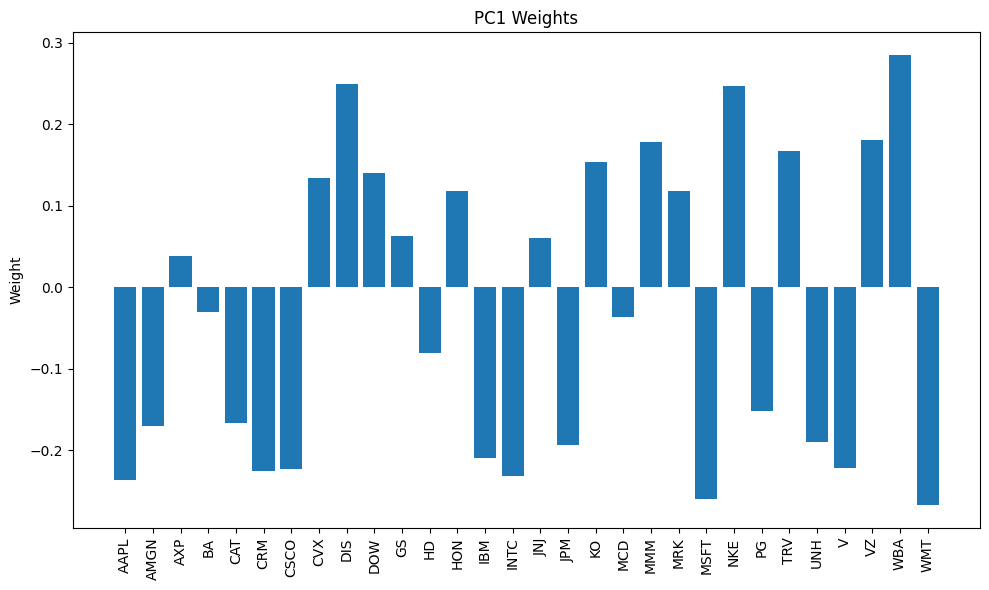

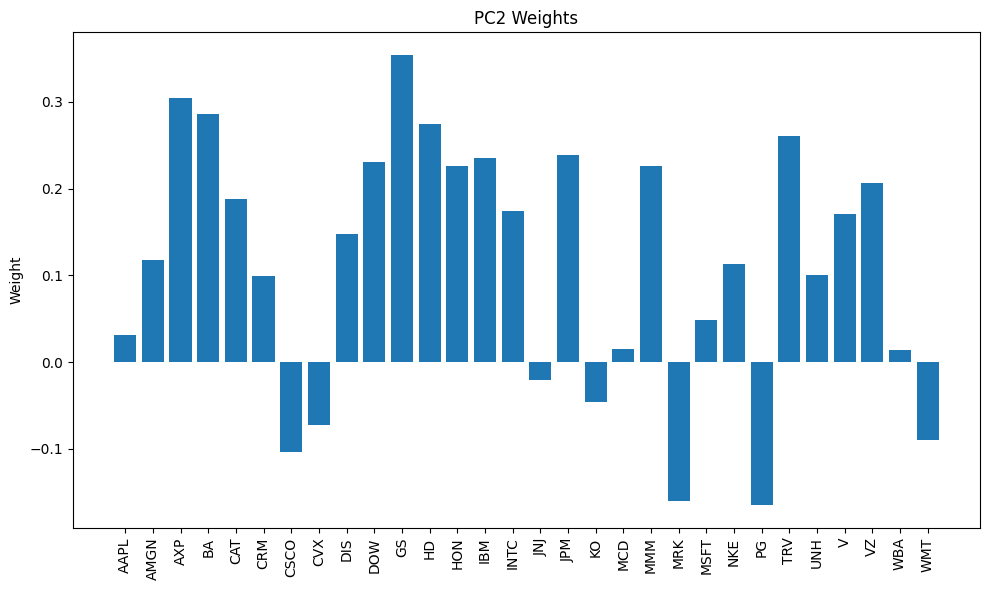

Similarity for pc1: -0.025261596442508173
Similarity for pc2: 0.11351657953642613


In [ ]:


# List of tickers
tickers = [
    "MMM", "AXP", "AMGN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DIS",
    "DOW", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK",
    "MSFT", "NKE", "PG", "CRM", "TRV", "UNH", "VZ", "V", "WBA", "WMT"
]

# Sort the tickers
tickers.sort()

# load data
dow_jones_data = yf.download(tickers, start="2023-01-01", end="2023-12-31")

adj_close = dow_jones_data["Adj Close"]

daily_returns = adj_close.pct_change() * 100





# correlation matrix
correlation_matrix = adj_close.corr()

#PCA
pca = PCA()
pca.fit(correlation_matrix)

#principal component weights
p_components = pca.components_

#bar graphs
def plot(pc, title):
    plt.figure(figsize=(10, 6))
    plt.bar(tickers, pc)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.ylabel('Weight')
    plt.tight_layout()
    plt.show()

plot(p_components[0], "PC1 Weights")
plot(p_components[1], "PC2 Weights")

#Comparison
equal_weight = np.ones(len(tickers)) / len(tickers)

similarity_for_pc1 = np.dot(p_components[0], equal_weight)
similarity_for_pc2 = np.dot(p_components[1], equal_weight)

print("Similarity for pc1:", similarity_for_pc1)
print("Similarity for pc2:", similarity_for_pc2)



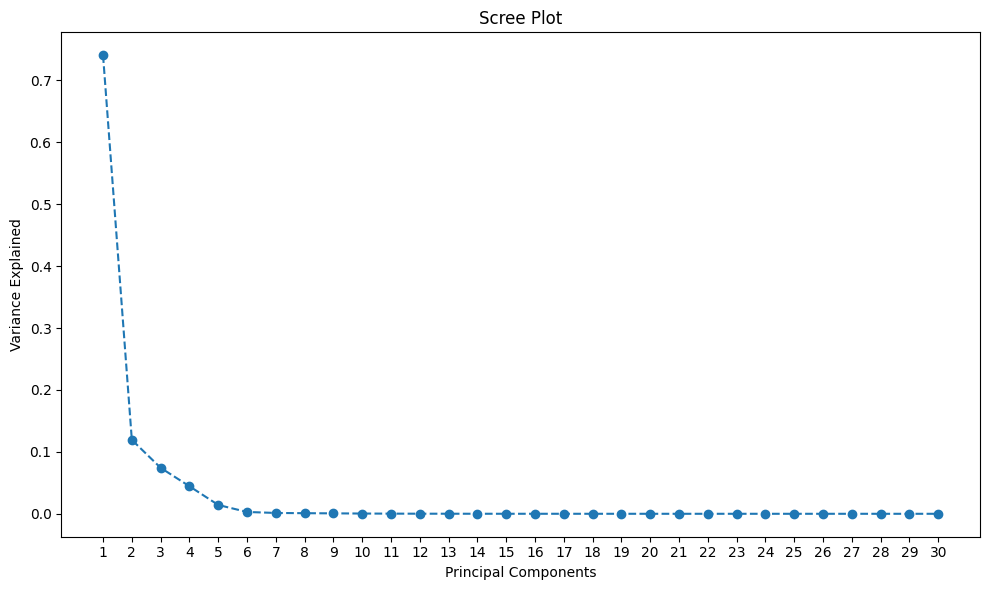

Number of components required to explain 95% of the variance: 4


In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.tight_layout()
plt.show()

cumulative_variance = np.cumsum(explained_variance_ratio)
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components required to explain 95% of the variance: {num_components_95}")


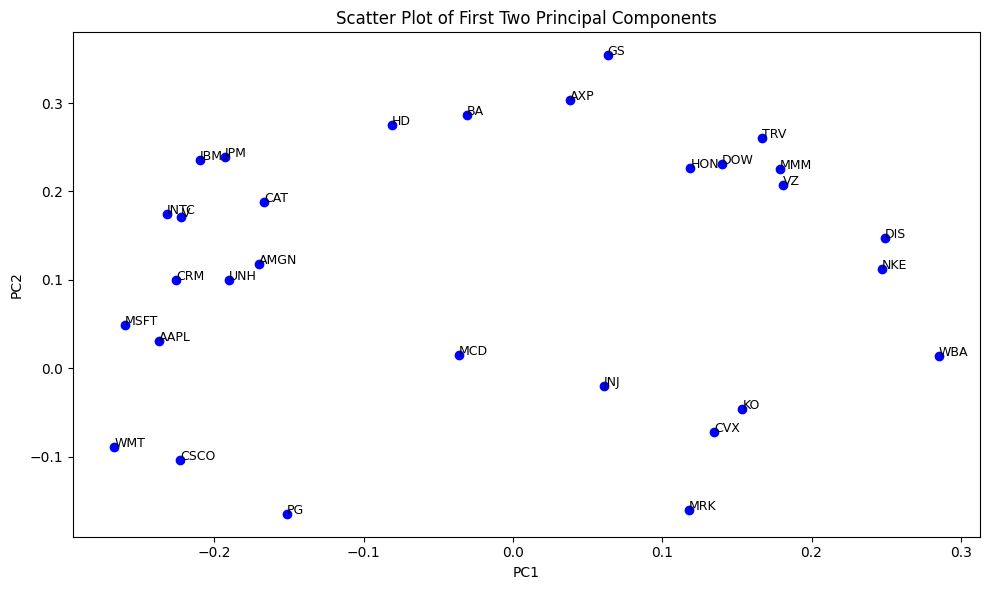

Mean of PC1: -0.02526159644250817
Mean of PC2: 0.11351657953642612

Three most distant stocks for PC1:
WBA - Distance: 0.3104793241004253
DIS - Distance: 0.2745274557698972
NKE - Distance: 0.27241870164272963

Three most distant stocks for PC2:
PG - Distance: 0.27831171033158036
MRK - Distance: 0.2740820097109635
GS - Distance: 0.2405333620283881


In [ ]:


# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(p_components[0], p_components[1], color='blue')
for i, ticker in enumerate(tickers):
    plt.text(p_components[0][i], p_components[1][i], ticker, fontsize=9)
plt.title('Scatter Plot of First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

mean_pc1 = np.mean(p_components[0])
mean_pc2 = np.mean(p_components[1])

distances_pc1 = np.abs(p_components[0] - mean_pc1)
distances_pc2 = np.abs(p_components[1] - mean_pc2)

sorted_indices_pc1 = np.argsort(distances_pc1)[::-1][:3]
sorted_indices_pc2 = np.argsort(distances_pc2)[::-1][:3]

print("Mean of PC1:", mean_pc1)
print("Mean of PC2:", mean_pc2)

print("\nThree most distant stocks for PC1:")
for i in sorted_indices_pc1:
    print(f"{tickers[i]} - Distance: {distances_pc1[i]}")

print("\nThree most distant stocks for PC2:")
for i in sorted_indices_pc2:
    print(f"{tickers[i]} - Distance: {distances_pc2[i]}")


In [ ]:
distance_matrix = np.sqrt(2 * (1 - correlation_matrix))

<ipython-input-95-6e2b7374d430>:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


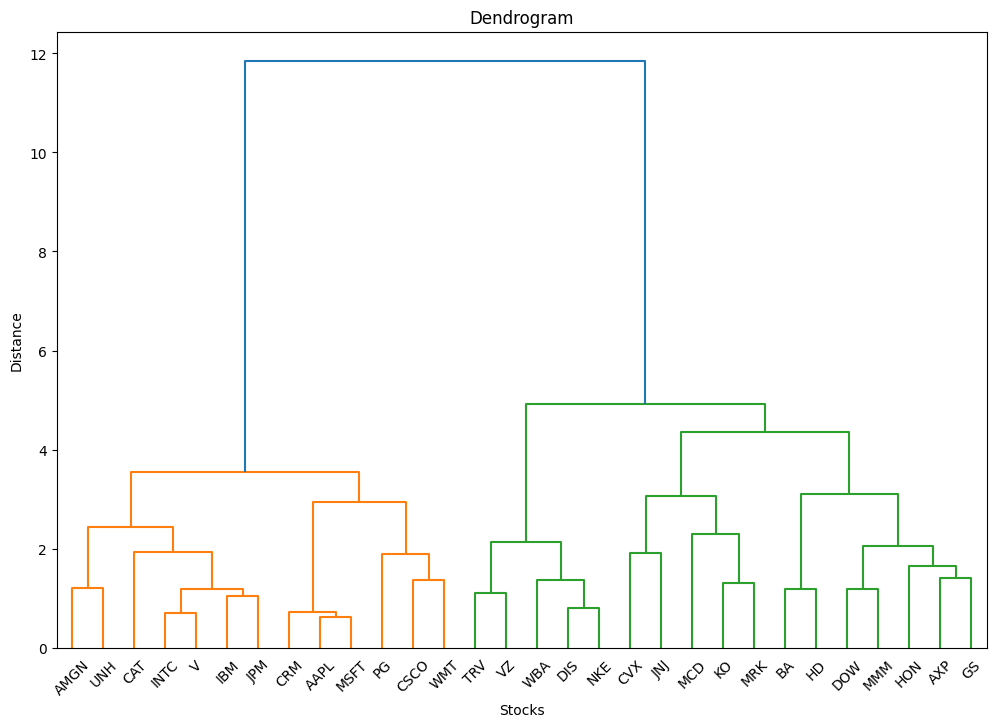

In [ ]:
linkage_matrix = linkage(distance_matrix, method='ward')

# Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=tickers, orientation='top', distance_sort='ascending')
plt.title("Dendrogram")
plt.xlabel("Stocks")
plt.ylabel("Distance")
plt.show()

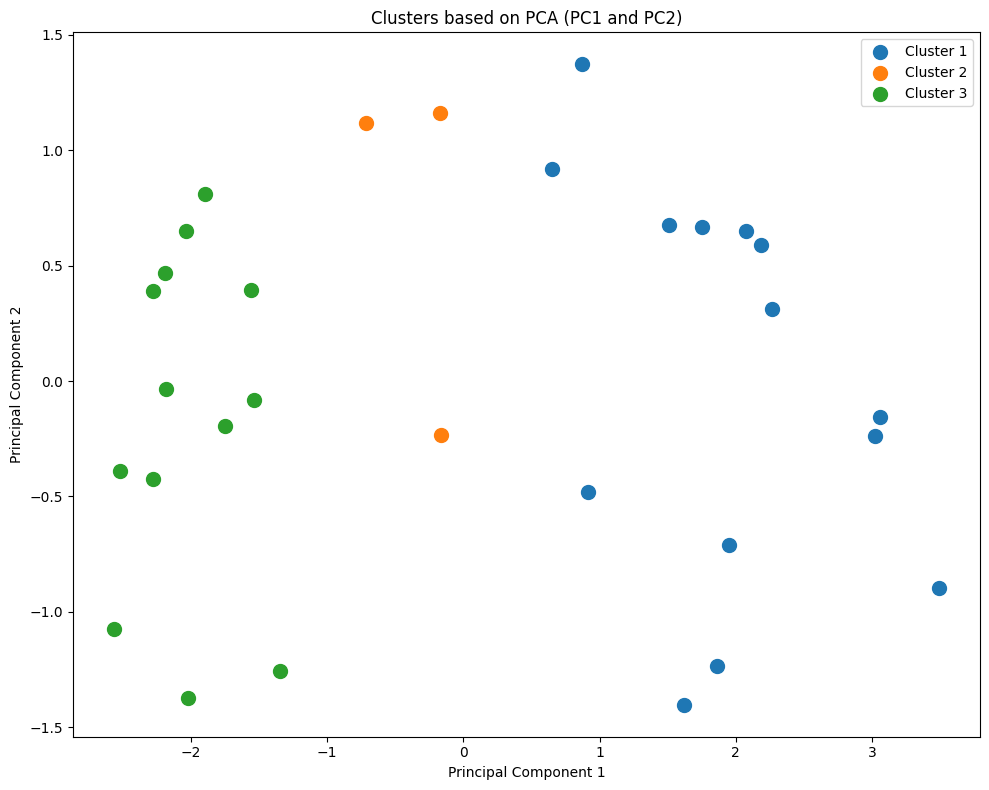


Cluster 1:
['AXP' 'CVX' 'DIS' 'DOW' 'GS' 'HON' 'JNJ' 'KO' 'MMM' 'MRK' 'NKE' 'TRV'
 'VZ' 'WBA']

Cluster 2:
['BA' 'HD' 'MCD']

Cluster 3:
['AAPL' 'AMGN' 'CAT' 'CRM' 'CSCO' 'IBM' 'INTC' 'JPM' 'MSFT' 'PG' 'UNH' 'V'
 'WMT']


In [ ]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(correlation_matrix)

linkage_matrix = linkage(correlation_matrix, method='ward')
clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')

df_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters
df_pca['Ticker'] = tickers

# Plotting the clusters
plt.figure(figsize=(10, 8))
for cluster in np.unique(clusters):
    cluster_data = df_pca[df_pca['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f"Cluster {cluster}", s=100)

plt.title("Clusters based on PCA (PC1 and PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()

for cluster in np.unique(clusters):
    print(f"\nCluster {cluster}:")
    print(df_pca[df_pca['Cluster'] == cluster]['Ticker'].values)



<ipython-input-106-745c15177962>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic_data.fillna(method='ffill', inplace=True)


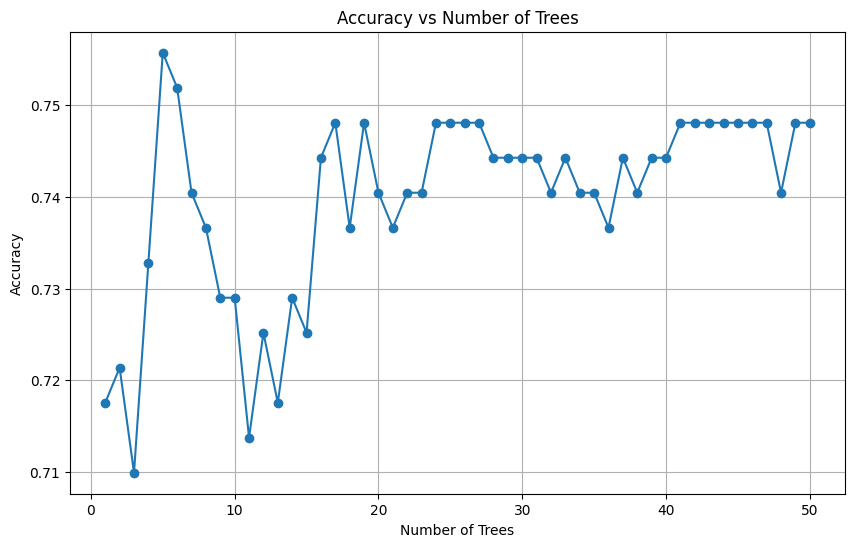

The optimal number of trees is 5 with an accuracy of 0.7557.


In [ ]:

url = "titanic3.csv"
titanic_data = pd.read_csv(url)


titanic_data.fillna(method='ffill', inplace=True)

label_encoder = LabelEncoder()
titanic_data['sex'] = label_encoder.fit_transform(titanic_data['sex'])
titanic_data['embarked'] = label_encoder.fit_transform(titanic_data['embarked'].astype(str))

features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']
X = titanic_data[features]
y = titanic_data['survived']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_trees = range(1, 51)
accuracies = []

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10,6))
plt.plot(n_trees, accuracies, marker='o')
plt.title('Accuracy vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

optimal_n_trees = n_trees[np.argmax(accuracies)]
print(f"The optimal number of trees is {optimal_n_trees} with an accuracy of {max(accuracies):.4f}.")


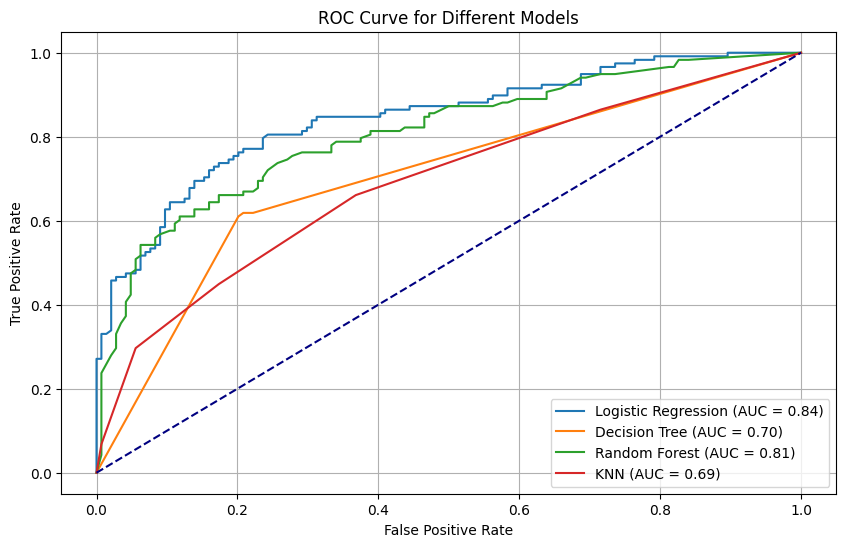

Logistic Regression: AUC = 0.84
Decision Tree: AUC = 0.70
Random Forest: AUC = 0.81
KNN: AUC = 0.69


In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

plt.figure(figsize=(10,6))

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve for Different Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f'{model_name}: AUC = {roc_auc:.2f}')


In [ ]:

url = "winequality-red.csv"
wine_data = pd.read_csv(url, sep=';')

X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(random_state=42)

# Use GridSearchCV to find the best number of leafs
param_grid = {'max_leaf_nodes': [5, 10, 20, 30, 40, 50, 60, 100]}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameter
best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
print(f"Optimal number of leafs: {best_max_leaf_nodes}")

# Train the model with the optimal number of leafs
rf_optimal = RandomForestRegressor(max_leaf_nodes=best_max_leaf_nodes, random_state=42)
rf_optimal.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_optimal.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimal number of leafs: 100
Mean Squared Error: 0.3610638374415015
R² Score: 0.4305197314704924


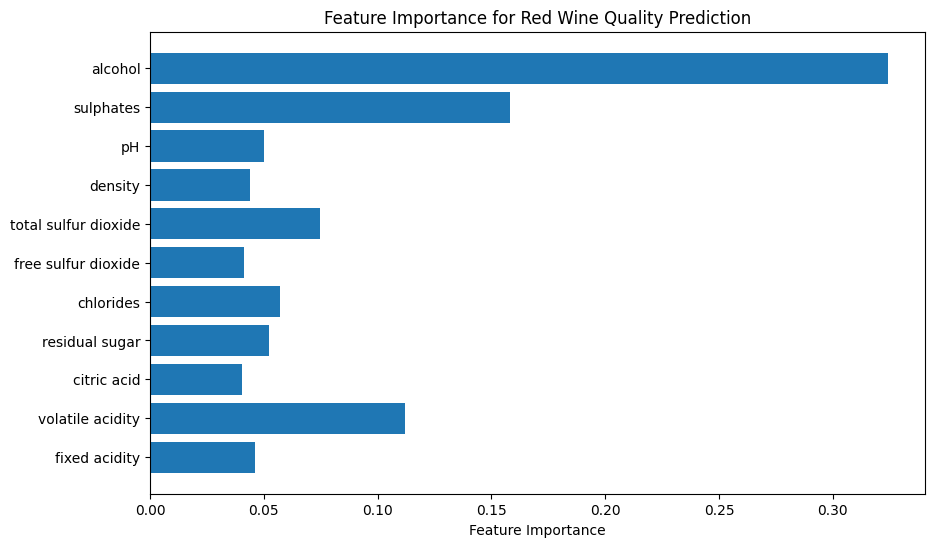

In [ ]:

importances = rf_optimal.feature_importances_
features = X.columns


plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Red Wine Quality Prediction')
plt.show()
